<a href="https://colab.research.google.com/github/hazmicokro/Cell-Images-Parasitized-Classification-using-ANN/blob/main/Cell_Images_Parasitized_Classification_using_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset: https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip**

## Download and Load Data

In [ ]:
# Library

from google.colab import drive

# U/ mengorganisir dataset pada folder
import os
import glob
import zipfile
import shutil
import cv2 
import numpy as np
import random
import urllib.request

# U/ pemodelan 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten,Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model


# U/ visualisasi plot dan report
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download dataset menggunakan urllib
url = 'https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip'
filename = '/content/gdrive/My Drive/Dataset/Modul 1/cell_images.zip'
urllib.request.urlretrieve(url, filename)
print("Selesai Download Dataset Cell Images")

Selesai Download Dataset Cell Images


#Ekstrak Dataset

In [ ]:
# ekstrak dataset 
ekstrak_zip = '/content/gdrive/My Drive/Dataset/Modul 1/cell_images.zip'
out_zip = zipfile.ZipFile(ekstrak_zip, 'r')
out_zip.extractall('/content/gdrive/My Drive/Dataset/Modul 1')
out_zip.close()

print('Selesai Ekstrak')

Selesai Ekstrak


Sebelum melakukan splitting jalankan fungsi berikut untuk memastikan isi folder hanya berupa gambar png

In [ ]:
# Pengecekan folder isi dataset
check_dir = "/content/drive/MyDrive/Dataset/Modul 1/cell_images"
print(os.listdir(check_dir))

['Parasitized', 'Uninfected', 'model_cell_images']


In [ ]:
# Pengecekan total data image berupa .png
total_image = len(list(glob.iglob("/content/gdrive/My Drive/Dataset/Modul 1/cell_images/*/*.png*", recursive=True)))
print("Total Data Image    : ",total_image," PNG Image \n")

Total Data Image    :  27558  PNG Image 



Note: 
- Fungsi untuk mendapatkan jumlah train gambar
- train_len_func = lambda x: int(70/100*len(x))
- Folder baru untuk training dan validasi path untuk data train dan data validation
- base_dir = 'model_cell_images'

Hasil dari pemindahan sehingga membentuk directory struktur berikut
- model_cell_images/training/Parasitized/*file gambar training parasit
- model_cell_images/training/Uninfected/*file gambar training uninfected
- model_cell_images/validation/Parasitized/*file gambar validation parasit
- model_cell_images/validation/Uninfected/*file gambar validation uninfected

In [ ]:
# Proses pengalokasian dataset
root_dir = "/content/drive/MyDrive/Dataset/Modul 1/cell_images/"
class_dirs = ['Parasitized','Uninfected']

# pengaturan letak train dan val
train_dir = "/content/drive/MyDrive/Dataset/Modul 1/cell_images/model_cell_images/training"
val_dir = "/content/drive/MyDrive/Dataset/Modul 1/cell_images/model_cell_images/validation"

# pembuatan jalur
train_path = os.path.join(root_dir, train_dir)  
validation_path = os.path.join(root_dir, val_dir)

random_seed = 240

for class_dir in class_dirs:
    
    # pembuatan jalur folder / directory
    os.makedirs(os.path.join(train_path,class_dir))
    os.makedirs(os.path.join(validation_path,class_dir))
    print(f'Selesai Membuat Folder {class_dir}')
    
    # shuffle dan alokasi 70% train dan 30% val
    src = os.path.join(root_dir,class_dir) 
    file_list = os.listdir(src)
    random.shuffle(file_list)
    threshold = int(len(file_list) * (70/100))
    train_files, validation_files = file_list[0:threshold], file_list[threshold:]
    
    # append jalur untuk tiap file (parasitzd n uninfectd)
    train_files = [os.path.join(src,name) for name in train_files]
    validation_files = [os.path.join(src,name) for name in validation_files]
    
    # Copy-paste images untuk tiap jalur file (parasitzd n uninfectd)
    for name in train_files:
        shutil.copy(name, os.path.join(train_path,class_dir))
    for name in validation_files:
        shutil.copy(name, os.path.join(validation_path,class_dir))
    
    print(f'Total {class_dir} images: ', len(file_list))
    print(f'Training {class_dir} : ', len(train_files))
    print(f'Validation {class_dir} : ', len(validation_files))
    print()

Selesai Membuat Folder Parasitized
Total Parasitized images:  13779
Training Parasitized :  9645
Validation Parasitized :  4134

Selesai Membuat Folder Uninfected
Total Uninfected images:  13779
Training Uninfected :  9645
Validation Uninfected :  4134



In [ ]:
train_parasitized_dir = "/content/drive/MyDrive/Dataset/Modul 1/cell_images/model_cell_images/training/Parasitized"
train_uninfected_dir = "/content/drive/MyDrive/Dataset/Modul 1/cell_images/model_cell_images/training/Uninfected"
validation_parasitized_dir = "/content/drive/MyDrive/Dataset/Modul 1/cell_images/model_cell_images/validation/Parasitized"
validation_uninfected_dir = "/content/drive/MyDrive/Dataset/Modul 1/cell_images/model_cell_images/validation/Uninfected"

print(os.listdir(train_parasitized_dir)[:5])
print(os.listdir(train_uninfected_dir)[:5])

print('')
print('total training parasitized images :', len(os.listdir(train_parasitized_dir)))
print('total training uninfected images:', len(os.listdir(train_uninfected_dir)))
print('total validation parasitized images:', len(os.listdir(validation_parasitized_dir)))
print('total validation uninfected images:', len(os.listdir(validation_uninfected_dir)))

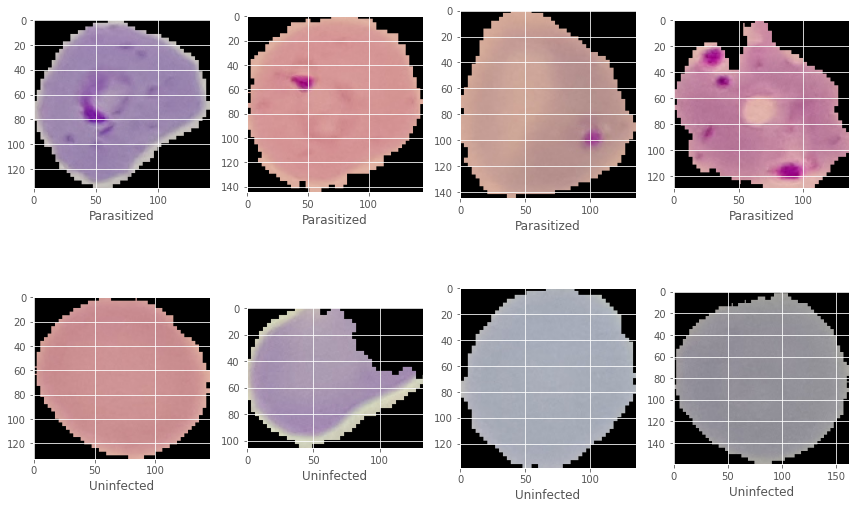

In [ ]:
# pengaturan letak folder / dir
parasitized_dir = "/content/gdrive/My Drive/Dataset/Modul 1/cell_images/Parasitized/"
uninfected_dir  = "/content/gdrive/My Drive/Dataset/Modul 1/cell_images/Uninfected/"

list1 = [parasitized_dir,uninfected_dir]

fig = plt.figure(figsize=(12, 8))
plt.style.use("ggplot")

j=1
for i in list1: 
    for k in range(4):
        filenames  = os.listdir(i)
        sample = random.choice(filenames)
        image = load_img(i+sample)
        plt.subplot(2,4,j)
        plt.imshow(image)
        plt.xlabel(i.split("/")[-2])
        j+=1
plt.tight_layout()

# 2. Preprocessing

In [ ]:
# Gather data train dg image 100x100
training_dir = os.path.join('/content/gdrive/My Drive/Dataset/Modul 1/cell_images/model_cell_images/training')

train_data = []
train_label = []
for r, d, f in os.walk(training_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (100,100))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

print('Selesai Gather Data Train')

Selesai Gather Data Train


In [ ]:
# Gather data validation dg image 100x100
validation_dir = os.path.join('/content/gdrive/My Drive/Dataset/Modul 1/cell_images/model_cell_images/validation')

val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".png" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (100,100))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

print('Selesai Gather Data Validation')

Selesai Gather Data Validation


In [ ]:
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (19290, 100, 100, 3)
Train Label =  (19290,)
Validation Data =  (8268, 100, 100, 3)
Validation Label =  (8268,)


In [ ]:
# Normalisasi data
print("Data sebelum di-normalisasi ", train_data[0][0][0])
x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [0 0 0]
Data setelah di-normalisasi  [0. 0. 0.]


In [ ]:
print("Label sebelum di-encoder ", train_label[995:1005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train[995:1005])

Label sebelum di-encoder  ['Parasitized' 'Parasitized' 'Parasitized' 'Parasitized' 'Parasitized'
 'Parasitized' 'Parasitized' 'Parasitized' 'Parasitized' 'Parasitized']
Label setelah di-encoder  [0 0 0 0 0 0 0 0 0 0]


# Model ANN

In [ ]:
model =  Sequential([
    # Input Layer
    Input(shape=(100,100, 3)),
   
    # Meratakan input menjadi 1 dimensi
    Flatten(),
    
    # Hidden layer penggunaan neuron dengan activation relu
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),

    # Output Layer berupa 1 neuron dengan activation sigmoid
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 30000)             0         
_________________________________________________________________
dense_74 (Dense)             (None, 512)               15360512  
_________________________________________________________________
dense_75 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_76 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_77 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 16)              

In [ ]:
Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.80):
      print("\n\n Akurasi train dan validasi didapat telah mencapai nilai > 80%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=32,
                    steps_per_epoch = len(x_train) // 32,
                    epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=[callbacks])

Epoch 1/200
602/602 [==============================] - 61s 101ms/step - loss: 0.7228 - accuracy: 0.5783 - val_loss: 0.6616 - val_accuracy: 0.6403
Epoch 2/200
602/602 [==============================] - 61s 101ms/step - loss: 0.6417 - accuracy: 0.6259 - val_loss: 0.6486 - val_accuracy: 0.6505
Epoch 3/200
602/602 [==============================] - 60s 100ms/step - loss: 0.6278 - accuracy: 0.6478 - val_loss: 0.6266 - val_accuracy: 0.6489
Epoch 4/200
602/602 [==============================] - 60s 100ms/step - loss: 0.6253 - accuracy: 0.6528 - val_loss: 0.6249 - val_accuracy: 0.6615
Epoch 5/200
602/602 [==============================] - 60s 100ms/step - loss: 0.6121 - accuracy: 0.6627 - val_loss: 0.5994 - val_accuracy: 0.6834
Epoch 6/200
602/602 [==============================] - 60s 100ms/step - loss: 0.5995 - accuracy: 0.6740 - val_loss: 0.6021 - val_accuracy: 0.6696
Epoch 7/200
602/602 [==============================] - 61s 101ms/step - loss: 0.5917 - accuracy: 0.6831 - val_loss: 0.5918 -

#Hasil Model 

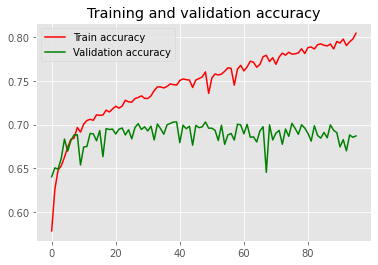

<Figure size 432x288 with 0 Axes>

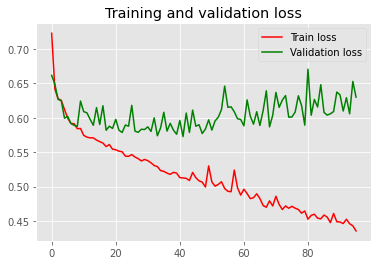

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Mengambil Nilai Loss 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Accruracy
plt.plot(epochs, acc, 'r', label='Train accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

# Plot Loss
plt.plot(epochs, loss, 'r', label='Train loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
pred = model.predict(x_train)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_train, labels))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      9645
           1       0.84      0.74      0.79      9645

    accuracy                           0.80     19290
   macro avg       0.80      0.80      0.80     19290
weighted avg       0.80      0.80      0.80     19290

